In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import torch, torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import v2
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class ISIC2024(Dataset):
    def __init__(self, image_dir, annotations_file, extension='.jpg', transform=None):
        # Specify the data types for the relevant columns
        dtype = {'isic_id': str, 'target': int}
        self.image_dir = image_dir
        self.annotations = pd.read_csv(annotations_file, dtype=dtype, low_memory=False)
        self.extension = extension
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.annotations.iloc[idx, 0] + self.extension)
        image = Image.open(img_name).convert("RGB")
        label = int(self.annotations.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Paths
image_dir = "D:/ISIC 2024 - Skin Cancer Detection with 3D-TBP/Data/train-image/image"  # Directory with images
annotations_file = "D:/ISIC 2024 - Skin Cancer Detection with 3D-TBP/Data/train-metadata.csv"  # CSV file with image names and labels

In [4]:
TRANS = v2.Compose([
    v2.Resize((224, 224)),      # ???
    v2.ToImage(),
    #v2.RandomRotation(degrees=(0, 360)),
    #v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale = True)
])
# TRANS = v2.Compose([
#     v2.Resize((224, 224)),
#     v2.ToTensor(),
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Example mean and std for ImageNet
# ])

In [5]:
dataset = ISIC2024(image_dir=image_dir, annotations_file=annotations_file, transform=TRANS)


In [6]:
annotations = pd.read_csv(annotations_file, low_memory=False)
labels = annotations['target']
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(annotations, labels))
train_subset = Subset(dataset, train_idx)
test_subset = Subset(dataset, test_idx)
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=16, shuffle=False)

In [7]:
print("Train set size:", len(train_subset))
print("Test set size:", len(test_subset))

Train set size: 320847
Test set size: 80212


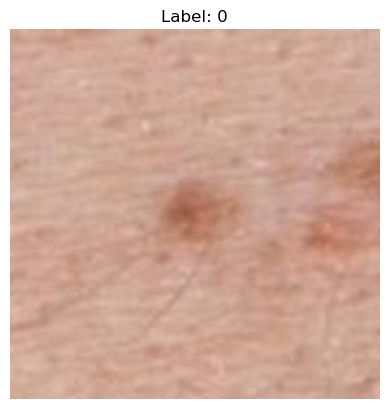

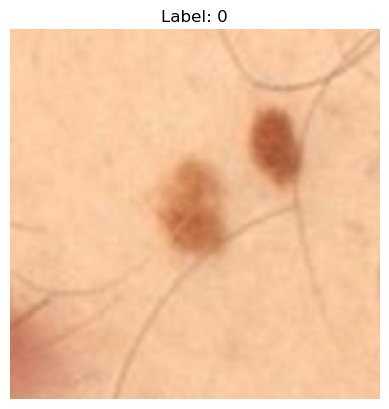

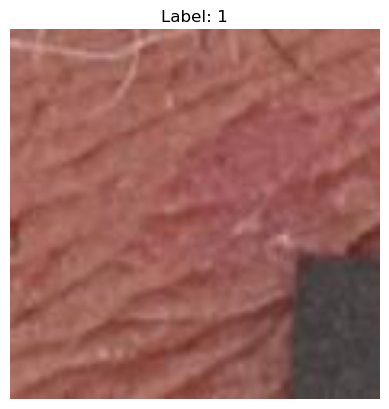

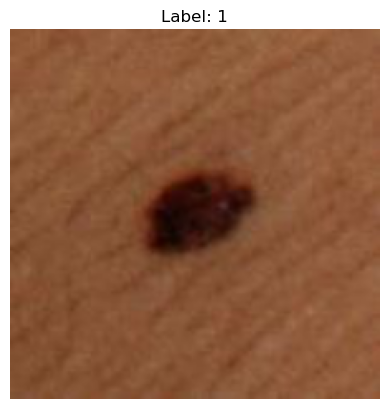

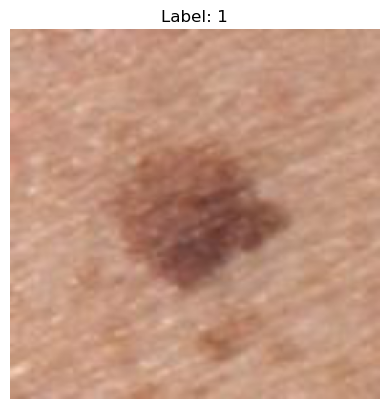

In [8]:
def show_images_with_labels(loader, target_label, num_images):
    count = 0
    for images, labels in loader:
        for image, label in zip(images, labels):
            if label == target_label and count < num_images:
                plt.imshow(image.permute(1, 2, 0))  # Convert from Tensor to numpy array and permute to (H, W, C)
                plt.title(f"Label: {label.item()}")
                plt.axis('off')
                plt.show()
                count += 1
            if count >= num_images:
                return

# Show 2 images with label = 0
show_images_with_labels(train_loader, target_label=0, num_images=2)

# Show 3 images with label = 1
show_images_with_labels(train_loader, target_label=1, num_images=3)